In [1]:
from datetime import datetime, timedelta
import pandas
import binance
from data_cache import pandas_cache
import numpy
from matplotlib import pyplot
from scipy import stats

COUNT_YEARS = 10
BINANCE_DATETIME_FORMAT = "%Y-%m-%d %H-%M-%S"

SYMBOL = 'ETHUSDT'
CURRENT_PRICE = 1683.
WINDOW_PERIOD = 21

@pandas_cache("code", "year")
def load_prices(client: binance.Client, code: str, year: int):
    from_date = datetime(year, 1, 1, 0, 0, 0)
    until_date = datetime(year + 1, 1, 1, 0, 0, 0) - timedelta(seconds=1)

    # Execute the query from binance - timestamps must be converted to strings !
    candles = client.get_historical_klines(code, binance.Client.KLINE_INTERVAL_1HOUR, str(from_date), str(until_date))

    # Create a dataframe to label all the columns returned by binance so we work with them later.
    df = pandas.DataFrame(candles, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime',
                                           'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol',
                                           'ignore'])

    # as timestamp is returned in ms, let us convert this back to proper timestamps.
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    df.dateTime = pandas.to_datetime(df.dateTime, unit='ms')
    df.set_index('dateTime', inplace=True)
    return df


# Create a client object
client = binance.Client()

current_year = datetime.now().year
df_years = list()
for year in range(current_year - COUNT_YEARS, current_year + 1):
    df = load_prices(client, SYMBOL, year)
    df = df.drop(['closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'], axis=1)
    df_years.append(df)

prices_df = pandas.concat(df_years, axis=0)
prices_df.index = pandas.to_datetime(prices_df.index)

daily_prices = prices_df.groupby(prices_df.index.date)['open'].first()




**Draw-down probability**

<Axes: >

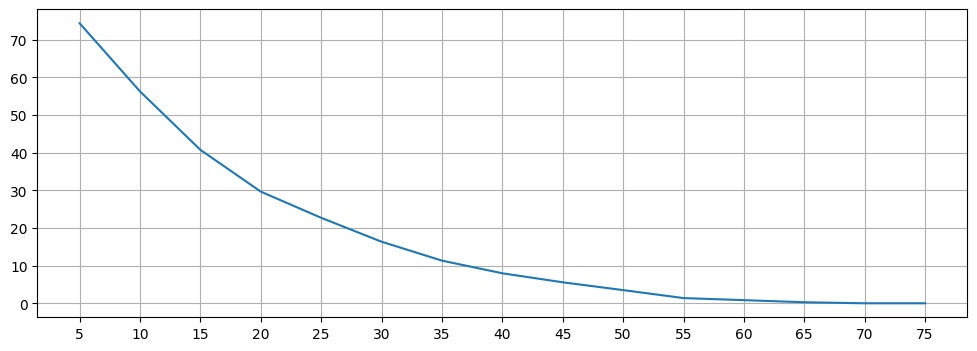

In [2]:
rolling_min_series = prices_df.groupby(prices_df.index.date)['low'].min().rolling(WINDOW_PERIOD).min()
period_close_series = prices_df.groupby(prices_df.index.date)['close'].last().shift(-WINDOW_PERIOD)
df = pandas.DataFrame({
    'daily_prices': daily_prices, 
    'period_close_series': period_close_series, 
    'rolling_min_series': rolling_min_series
})
df['rolling_min_series'] = df['rolling_min_series'].shift(-WINDOW_PERIOD)
df['drawdown_pct'] = -df['rolling_min_series'].divide(df['daily_prices']).subtract(1.).multiply(100.)
df['period_perf_pct'] = df['period_close_series'].divide(df['daily_prices']).subtract(1.).multiply(100.)
df.dropna(inplace=True)
df.index = pandas.to_datetime(df.index) 
frequencies = dict()
for loss in range(5, 80, 5):
    frequencies[loss] = 100. * df['drawdown_pct'][df['drawdown_pct'] > loss].count() / df['drawdown_pct'].count()

df = df[df.index.year>=2019]    

pandas.Series(frequencies, name='loss_distribution').plot(figsize=(12,4), grid=True, xticks=list(frequencies.keys()))

**Performance distribution**

Text(0.5, 1.0, 'Period (21 days) Performance Underlying')

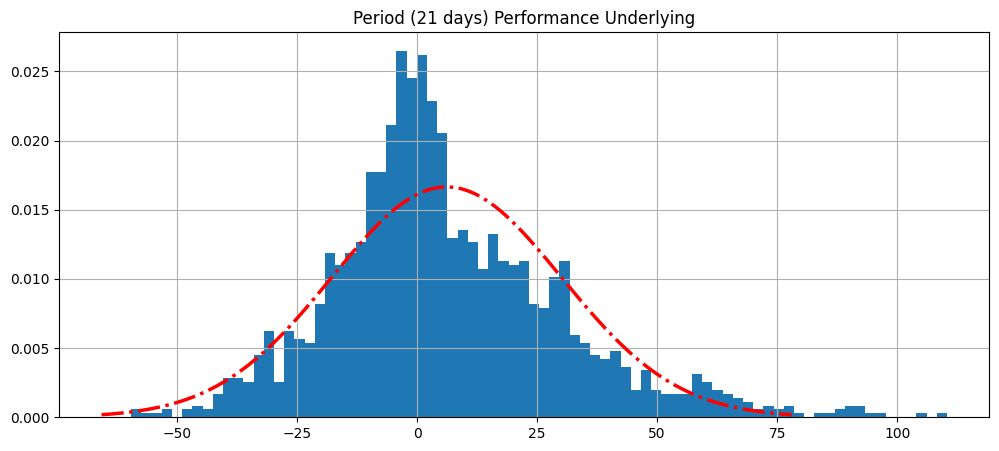

In [3]:
df['period_perf_pct'].hist(bins=80, density=True, figsize=(12, 5))

mu = df['period_perf_pct'].describe()['mean']
sigma = df['period_perf_pct'].describe()['std']
# Generate the normal distribution curve
x = numpy.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y = stats.norm.pdf(x, mu, sigma)

# Plot the normal distribution curve
pyplot.plot(x, y, linestyle='dashdot', linewidth=2.5, color='red')
pyplot.title(f'Period ({WINDOW_PERIOD} days) Performance Underlying')

Text(0.5, 1.0, 'Daily Performance Underlying')

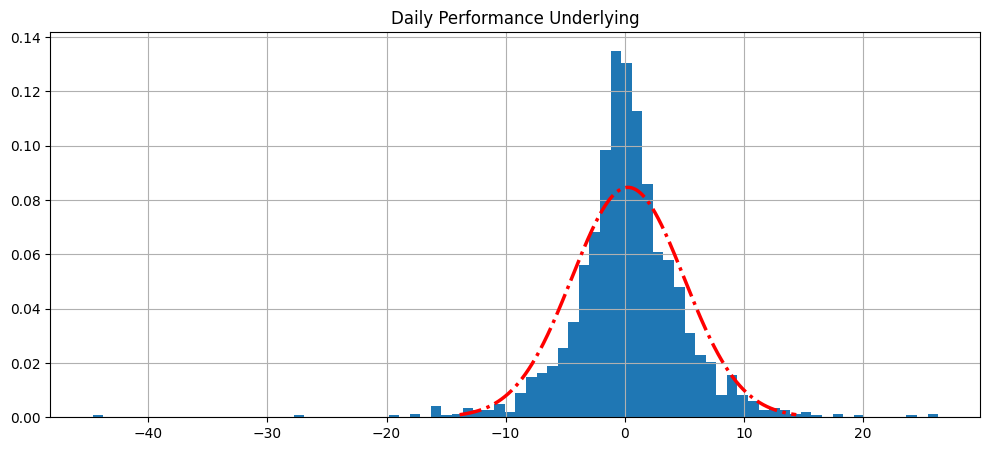

In [4]:
daily_perf = df["daily_prices"].shift(-1).divide(df["daily_prices"]).subtract(1.).dropna().multiply(100.)
daily_perf.hist(bins=80, density=True, figsize=(12, 5))

mu = daily_perf.describe()['mean']
sigma = daily_perf.describe()['std']
# Generate the normal distribution curve
x = numpy.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y = stats.norm.pdf(x, mu, sigma)

# Plot the normal distribution curve
pyplot.plot(x, y, linestyle='dashdot', linewidth=2.5, color='red')
pyplot.title('Daily Performance Underlying')

## Option valuation model

<Axes: >

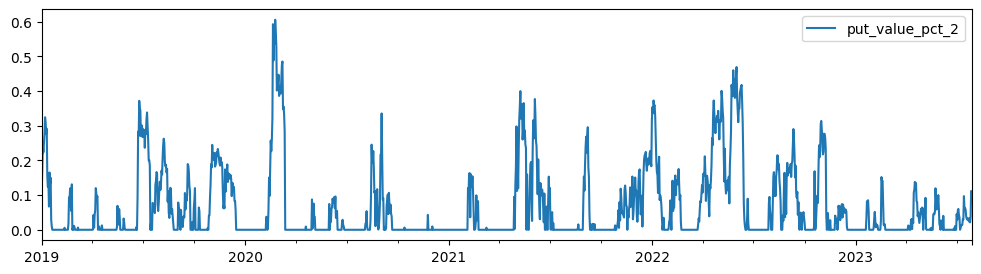

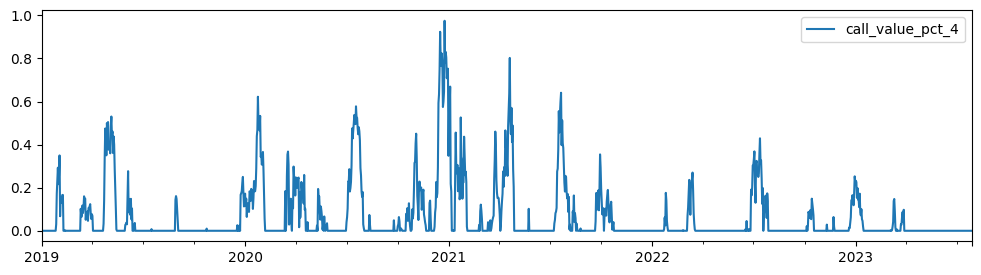

In [5]:
def generate_strikes(price: float):
    closest_hundred = round(price / 100.) * 100.
    strikes = set()
    strikes.add(closest_hundred)
    for i in range(1, 3):
        strikes.add(closest_hundred + i * 100.)
        strikes.add(closest_hundred - i * 100.)
        
    return strikes

strike_prices = list(generate_strikes(CURRENT_PRICE))
for count, strike_price in enumerate(strike_prices, start=1):
    strike_factor = strike_price / CURRENT_PRICE
    df[f'strike_{count}'] = df['daily_prices'].multiply(strike_factor)
    df[f'strike_pct_{count}'] = strike_factor
    
    df[f'call_value_{count}'] = df['period_close_series'].subtract(df[f'strike_{count}'])
    df[f'call_value_{count}'].loc[df[f'call_value_{count}'] < 0.] = 0.
    df[f'call_value_pct_{count}'] = df[f'call_value_{count}'].divide(df['daily_prices'])
    
    df[f'put_value_{count}'] = df[f'strike_{count}'].subtract(df['period_close_series'])
    df[f'put_value_{count}'].loc[df[f'put_value_{count}'] < 0.] = 0.
    df[f'put_value_pct_{count}'] = df[f'put_value_{count}'].divide(df['daily_prices'])
    

df[['put_value_pct_2']].plot(figsize=(12,3))
df[['call_value_pct_4']].plot(figsize=(12,3))


<Axes: >

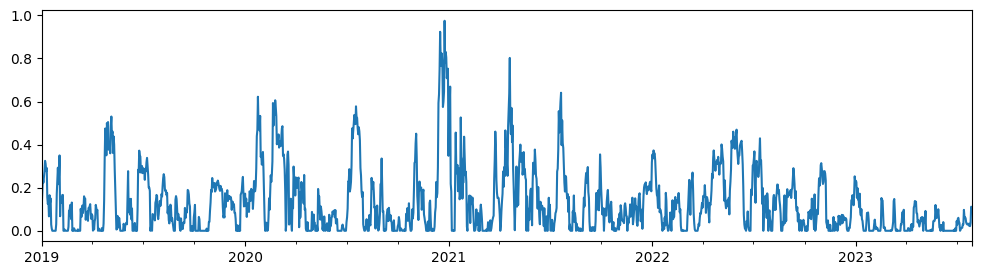

In [6]:
df['call_value_pct_4'].add(df['put_value_pct_2']).plot(figsize=(12,3))

In [7]:
option_chain = list()
for count, strike_price in enumerate(strike_prices, start=1):
    strike_data = {
        'strike': strike_price,
        'value_call': df[f'call_value_pct_{count}'].mean() * CURRENT_PRICE,
        'value_put': df[f'put_value_pct_{count}'].mean() * CURRENT_PRICE,
        'value_call_median': df[f'call_value_pct_{count}'].quantile(0.5) * CURRENT_PRICE,
        'value_put_median': df[f'put_value_pct_{count}'].quantile(0.5) * CURRENT_PRICE,
        'value_call_pct': df[f'call_value_pct_{count}'].mean(),
        'value_put_pct': df[f'put_value_pct_{count}'].mean()
    }
    if strike_price < CURRENT_PRICE:
        strike_data['value_call_pct'] = None
    if strike_price > CURRENT_PRICE:
        strike_data['value_put_pct'] = None
        
    option_chain.append(strike_data)
    
pandas.DataFrame(option_chain).set_index('strike').sort_index()

,value_call,value_put,value_call_median,value_put_median,value_call_pct,value_put_pct
strike,,,,,,
1500.0,328.549177,42.288378,220.126054,0.000000,NaN,0.025127
1600.0,254.649497,68.388698,120.126054,0.000000,NaN,0.040635
1700.0,193.887453,107.626654,20.126054,0.000000,0.115203,NaN
1800.0,147.775271,161.514472,0.000000,79.873946,0.087805,NaN
1900.0,111.346003,225.085204,0.000000,179.873946,0.066159,NaN


In [8]:
df.sample(1, random_state=42).transpose()

,2021-07-30
daily_prices,2382.930000
period_close_series,3284.820000
rolling_min_series,2420.680000
drawdown_pct,-1.584184
period_perf_pct,37.847943
strike_1,2265.411765
strike_pct_1,0.950683
call_value_1,1019.408235
call_value_pct_1,0.427796
put_value_1,0.000000


<Axes: >

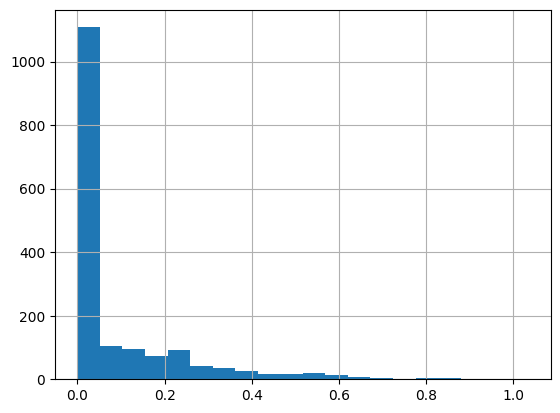

In [9]:
df[f'call_value_pct_3'].hist(bins=20)

In [10]:
df[f'call_value_pct_3'].describe()

count    1670.000000
mean        0.087805
std         0.159184
min         0.000000
25%         0.000000
50%         0.000000
75%         0.123659
max         1.034089
Name: call_value_pct_3, dtype: float64

<Axes: title={'center': 'EWM 120 days price'}>

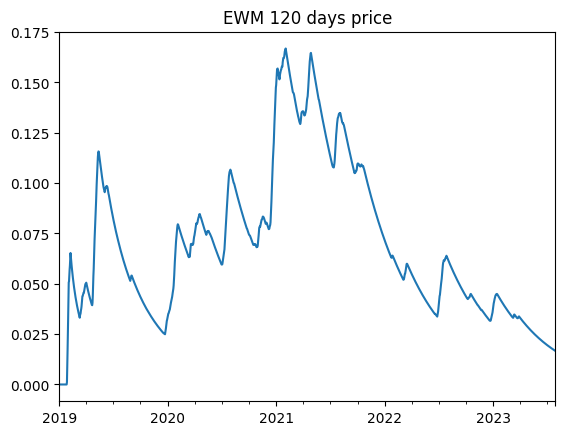

In [11]:
df[f'call_value_pct_4'].ewm(halflife='120 days', times=df.index).mean().plot(title='EWM 120 days price')

<Axes: >

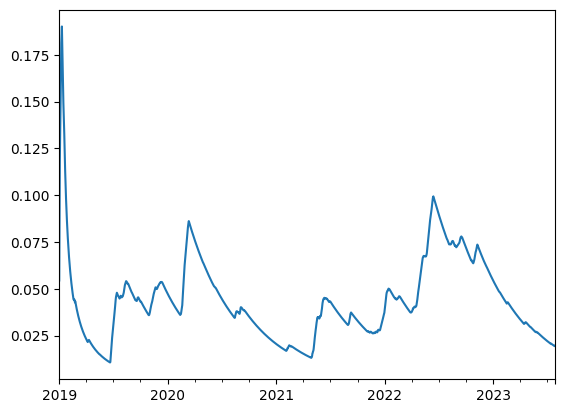

In [12]:
df[f'put_value_pct_1'].ewm(halflife='120 days', times=df.index).mean().plot()

In [14]:
daily_prices

2017-08-17     301.13
2017-08-18     302.00
2017-08-19     293.31
2017-08-20     289.41
2017-08-21     299.10
               ...   
2023-08-14    1840.73
2023-08-15    1845.50
2023-08-16    1828.98
2023-08-17    1807.81
2023-08-18    1681.49
Name: open, Length: 2193, dtype: float64